# Homework 07 - Challenge

In this homework you will apply your knowledge to create the best possible neural network to solve the FashionMNIST dataset. You can use everything that you have learned so far.

The challenge is hosted on Kaggle: https://www.kaggle.com/t/26e38cf09340459cb798670a65c1e239

You have to download the files 'train.csv' and 'test.csv' and place them in the same folder as below. Then run the next two cells.

The first one imports all required libraries.  
The second one loads the training data and splits it up into training and validation data. You should use the validation data for testing whether you model is able to generalize.

The test data is only used to generate your submission files.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the training data and split up into training and validation data.
train_df = pd.read_csv('kaggle_resources/train/train.csv')
train_images = np.reshape(train_df.values[:,1:], newshape=(-1,28,28))
train_labels = train_df.values[:,0]
validation_images = train_images[50000:,:,:]
validation_labels = train_labels[50000:]
train_images = train_images[:50000,:,:]
train_labels = train_labels[:50000]

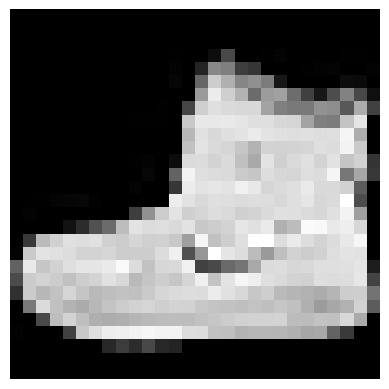

In [3]:
# Make sure the images are as desired:
plt.imshow(train_images[0],cmap='gray')
plt.axis('off')
plt.show()

### Build the TensorFlow dataset.

In [4]:
# We normalize our training and test images from values between 0 and 255 
# to values between 0 and 1 to apply our activation functions appropriately.
# That means we convert them to numpy arrays and back to tensors after the normalization.
train_images = np.array(train_images, dtype=np.float32) / 255.0
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_images = np.array(validation_images, dtype=np.float32) / 255.0
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

# It makes sense to shuffle the training dataset.
train_dataset = train_dataset.shuffle(buffer_size=50000)
# Further we have seen that it is advantageous to train with mini-batches instead of one sample at a time.
train_dataset = train_dataset.batch(32)
# The test dataset can be processed in full batch.
validation_dataset = validation_dataset.batch(10000)

### Build the model.

In [5]:
# Import necessary layer package from keras.
from tensorflow.keras.layers import Layer

class Model(Layer):

    # For the classification task we use a mix of convolutional, maxpooling, flatten and dense layers.
    def __init__(self):
        super(Model, self).__init__()
        # Initialize all layers.
        self.conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation = "relu", input_shape = (28, 28, 1))
        self.maxpool_1 = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (1,1))
        self.conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation = "relu")
        self.maxpool_2 = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (1,1))
        self.conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation = "relu")
        self.maxpool_3 = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (1,1))
        self.conv_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation = "relu")
        self.flatten = tf.keras.layers.Flatten()
        self.dense_layer = tf.keras.layers.Dense(units=64, activation = "relu")
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
        
    def call(self, x):
      # Computing the forward step: Input runs through every layer and the last layer produces the output.
        x = tf.reshape(x, shape=(-1,28,28,1))
        x = self.conv_1(x)
        x = self.maxpool_1(x)
        x = self.conv_2(x)
        x = self.maxpool_2(x)
        x = self.conv_3(x)
        x = self.maxpool_3(x)
        x = self.conv_4(x)
        x = self.flatten(x)
        x = self.dense_layer(x)
        x = self.output_layer(x)
        return x

### Train the model.

In [6]:
# Clear the session to get rid of everything that might be stored in the background.
tf.keras.backend.clear_session()

# Initialize model, loss (categorical cross entropy) and optimizer (Adam with default params).
model = Model()
cce = tf.keras.losses.CategoricalCrossentropy()
adam = tf.keras.optimizers.Adam()

# Initialize lists for later visualization.
train_steps = []
train_losses = []
train_accuracies = []
validation_steps = []
validation_losses = []
validation_accuracies = []
step = 0


for epoch in range(3):
    print(f"Epoch {epoch+1}/3")
    
    # We iterate through the tuples (input, target) of our training dataset.
    for (x,t) in train_dataset:
        # Turn the labels into one-hot vectors.
        t = tf.one_hot(t, 10)
        # Perform a training step.
        # For that, calculate the output, loss and gradients.
        with tf.GradientTape() as tape:
          output = model(x)
          loss = cce(t, output)
          gradients = tape.gradient(loss, model.trainable_variables)

        # Apply the gradients according to our optimizer.
        adam.apply_gradients(zip(gradients, model.trainable_variables))

        # Calculate the training accuracy every 25 steps and append the lists.
        if step % 25 == 0:
          accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]
          train_accuracies.append(accuracy)
          train_losses.append(loss)
          train_steps.append(step)
          
        # Calculate the test loss and accuracy every 50 steps.
        if step % 50 == 0:
          for (x,t) in validation_dataset:
            # Turn the labels into one-hot vectors again.
            t = tf.one_hot(t, 10)

            output = model(x)
            loss = cce(t, output)
            accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]
            validation_losses.append(loss)
            validation_accuracies.append(accuracy)
            validation_steps.append(step)

        # Monitoring the training process
        if step % 1000 == 0:
            print(f"Step: {step}, Loss: {loss}, Accuracy: {accuracy}")
        
        step += 1

Epoch 1/3
Step: 0, Loss: 3.363084077835083, Accuracy: 0.1008
Step: 1000, Loss: 0.3812939524650574, Accuracy: 0.8559
Epoch 2/3
Step: 2000, Loss: 0.31904321908950806, Accuracy: 0.8845
Step: 3000, Loss: 0.2925500273704529, Accuracy: 0.8925
Epoch 3/3
Step: 4000, Loss: 0.275864839553833, Accuracy: 0.8989


### Visualize the training process.

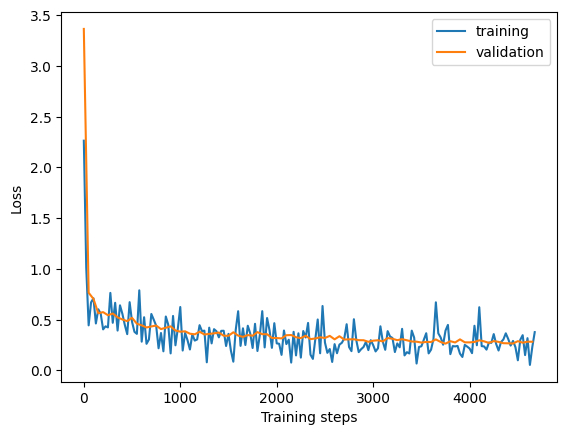

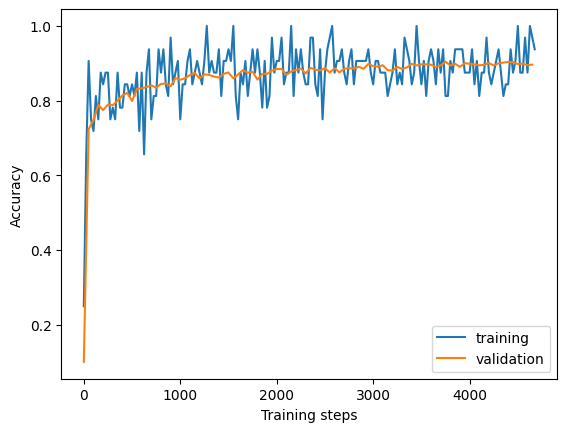

0.8964


In [7]:
# Visualize accuracy and loss for training and validation data. 
# One plot training and validation loss.
# One plot training and validation accuracy.
# Add a legend to show more clearly which line indicates which dataset.
plt.figure()
line1, = plt.plot(train_steps, train_losses)
line2, = plt.plot(validation_steps, validation_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","validation"))
plt.show()

plt.figure()
line1, = plt.plot(train_steps, train_accuracies)
line2, = plt.plot(validation_steps, validation_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1,line2),("training","validation"))
plt.show()

print(validation_accuracies[len(validation_accuracies)-1])

### Generate Submission File

In [ ]:
from datetime import datetime
now = datetime.now()
now_str = now.strftime('%d-%m-%Y-%H:%M:%S')

# Load the test data.
test_df = pd.read_csv('kaggle_resources/test/test.csv')
test_images = np.reshape(test_df.values[:,:], newshape=(-1,28,28))

# Get predictions.
output = model(test_images).numpy()
predictions = np.argmax(output, axis=1)

# Save submission file.
submission_data = np.zeros((10000,2), dtype=np.int)
submission_data[:,0] = np.arange(10000)
submission_data[:,1] = predictions
df_submission = pd.DataFrame(data=submission_data, columns=['ImageId','Prediction'], dtype=str)
df_submission.to_csv('submission-'+ now_str +'.csv', index=False)